#  <img src="./logo_transparent.png" width="70"> 1 - Loading Trails informations

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import numpy as np
from selenium import webdriver
import chromedriver_autoinstaller
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.ui import WebDriverWait
import pickle
import datetime

In [3]:
# To install latest version of chromedriver
chromedriver_autoinstaller.install()

'C:\\Users\\nimod\\anaconda3\\envs\\geo_env\\lib\\site-packages\\chromedriver_autoinstaller\\112\\chromedriver.exe'

### Structure des données de la class trail       
       .nom_id         Nom du trail
       .date           Date du trail
       .suivi          Site pour suivre le trail livetrail ou livetrack
       .heure_depart   Heure de départ du trail
       .csv_file       Nom du fichier avec les points de passage
       .df_ppassage    DataFrame avec les points de passage + les prédictions
       .df_parcours    DataFrame du parcours après chargement du fichier gpx
       .vit_plat       Paramètre  1 de correlation après correlation linéaire
       .vit_Dplus      Paramètre  2 de correlation après correlation linéaire
       .ralentissement Paramètre  3 de correlation après correlation linéaire

In [4]:
class trail:
    def __init__(self,nom_id,d,s,hd,csv):
        self.nom_id = nom_id 
        self.date = d
        self.suivi = s
        self.heure_depart =hd
        self.csv_file =csv
        
    def load_ppassage_csv(self):
        self.df_ppassage = pd.read_csv(f'./data/{self.csv_file}',sep=',')
        self.df_ppassage.loc[0,'Delta_reel_h']=0.0
        self.df_ppassage.loc[0,'Delta_Dist_km']=0
        self.df_ppassage.loc[0,'Delta_D+_m']=0
        for i in range(len(self.df_ppassage)-1):
            self.df_ppassage.loc[i+1,'Delta_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h']-self.df_ppassage.loc[i,'H_reel_h']
            self.df_ppassage.loc[i+1,'Delta_Dist_km']=self.df_ppassage.loc[i+1,'Cumul_Dist_km']-self.df_ppassage.loc[i,'Cumul_Dist_km']
            self.df_ppassage.loc[i+1,'Delta_D+_m']=self.df_ppassage.loc[i+1,'Cumul_D+_m']-self.df_ppassage.loc[i,'Cumul_D+_m']
        # display(self.df_ppassage)
        print(f'CSV File loaded under {self.nom_id}.df_ppassage')
    
    def remove_missing(self): # Elimine les empty cell et corrige s'il manque une heure de passage 
        if self.df_ppassage['Heure_Passage'].isnull().values.any():
            print('Il y a une heure de passage manquante',self.df_ppassage[self.df_ppassage['Heure_Passage'].isnull()]['Point_passage'])
            self.df_ppassage=self.df_ppassage.dropna(axis=0,subset=['Heure_Passage']).reset_index(drop=True)
            for i in range(1,len(self.df_ppassage)):             
                self.df_ppassage.loc[i,'Delta_Dist_km']=self.df_ppassage.loc[i,'Cumul_Dist_km']-self.df_ppassage.loc[i-1,'Cumul_Dist_km']
                self.df_ppassage.loc[i,'Delta_D+_m']=self.df_ppassage.loc[i,'Cumul_D+_m']-self.df_ppassage.loc[i-1,'Cumul_D+_m'] 
    
    def load_gpx(self, file):
        with open(file) as f:
            data=f.read().strip()
            data_parse =data.split('<trkpt')
            #utb_lst_elev = []
            parcours=[]
            for p in data_parse[1:]:
                pt={}
                try:
                    pt['alt'] = int(re.findall('<ele>(.+?)</ele>',p)[0])
                except:
                    pt['alt']='NA'
                pt['lat'] = float(re.findall('"(.+?)"',p)[0])
                pt['lon'] = float(re.findall('"(.+?)"',p)[1])
                parcours.append(pt)
        self.df_parcours = pd.DataFrame(parcours)
        print(f'gpx File loaded under {self.nom_id}.df_parcours')
         
    def load_data_livetrail(self,url): # Format heure depart XX:XX:XX
        coureur ='morand romain'
        # OLD install chrome web driver https://sites.google.com/a/chromium.org/chromedriver/downloads
        # OLD PATH = "C:\Program Files\chromedriver.exe"
        options = webdriver.ChromeOptions()
        driver = webdriver.Chrome(options=options)
        # driver = webdriver.Chrome(PATH)
        driver.get(url)
        time.sleep(1)
        inputElement = driver.find_element(By.NAME, "rech")
        inputElement.send_keys(coureur)
        inputElement.submit()
        time.sleep(2)
        tableau = driver.find_element(By.XPATH, '//*[@id="fc"]/div[3]/div[2]/a[1]')
        tableau.click()
        txt = driver.page_source
        txt = txt.replace('&nbsp;','').replace('\n','').replace('\t','')
        time.sleep(2)
        driver.close()
        # Extract 
        inter = re.findall('idpt:(.+?){',txt,re.DOTALL)
        table =[]
        for l in inter:
            point={}
            #print(l)
            point['id']= int(re.findall("'(.+?)',kmt",l,re.DOTALL)[0])
            point['Point_passage']=re.findall('n:"(.+?)"',l,re.DOTALL)[0]
            point['Altitude_m']=int(re.findall("a:'(.+?) m'",l,re.DOTALL)[0].replace(' ',''))
            point['Cumul_Dist_km']=float(re.findall("kmt:'(.+?) km'",l,re.DOTALL)[0].replace(',','.'))
            if 'NaN' in re.findall("kmp:'(.+?) km'",l,re.DOTALL)[0]:
                point['Delta_Dist_km']=0.0
            else:
                point['Delta_Dist_km']=float(re.findall("kmp:'(.+?) km'",l,re.DOTALL)[0].replace(',','.'))
            point['Cumul_D+_m']=int(re.findall("dt:'(.+?) m'",l,re.DOTALL)[0].replace(' ',''))
            try: point['Delta_D+_m']=int(re.findall("dp:'(.+?) m'",l,re.DOTALL)[0].replace(' ','')) 
            except: point['Delta_D+_m']=0
            point['lon']=float(re.findall("lon:'(.+?)'",l,re.DOTALL)[0])
            point['lat']=float(re.findall("lat:'(.+?)'",l,re.DOTALL)[0])
            try: point['Heure_Passage']=(re.findall("hp:'(.+?)',tc",l,re.DOTALL)[0])
            except: point['Heure_Passage']=''
            try: point['Temps_course']=(re.findall("tc:'(.+?)',clt",l,re.DOTALL)[0])
            except: point['Temps_course']=''
            try: point['Classement']=(re.findall("clt:'(.+?)',vit",l,re.DOTALL)[0])
            except: point['Classement']=''
            try: point['Vitesse_km/h']=float(re.findall("vit:'(.+?)km/h'",l,re.DOTALL)[0].replace(',','.')) 
            except: point['Vitesse_km/h']=0
            #print(point)
            table.append(point)
        self.df_ppassage=pd.DataFrame(table)
        # Conversion des données
        for i in range(len(self.df_ppassage)):
            try:
                self.df_ppassage.loc[i,'H_reel_h']=int(self.df_ppassage.loc[i,'Temps_course'].split(':')[0])+int(self.df_ppassage.loc[i,'Temps_course'].split(':')[1])/60+int(self.df_ppassage.loc[i,'Temps_course'].split(':')[2])/60/60
            except:
                 self.df_ppassage.loc[i,'H_reel_h']=0
        self.df_ppassage.loc[0,'Delta_reel_h']=0
        for i in range(len(self.df_ppassage)-1):
            self.df_ppassage.loc[i+1,'Delta_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h']-self.df_ppassage.loc[i,'H_reel_h']
        # Enregistrement
        self.csv_file = self.date+"_"+re.findall('Romain MORAND-(.+?)- Live',txt,re.DOTALL)[0].strip()+"_"+str(self.df_ppassage.loc[len(self.df_ppassage)-1,'Cumul_Dist_km'])+"km.csv"
        self.df_ppassage.to_csv(f'./data/{self.csv_file}', index=False)
        print('Livetrail data loaded under XXX.df_ppassage and .csv file')
    
    def load_data_before_livetrack(self, url): # # Format heure depart XX:XX:XX
        # install chrome web driver https://sites.google.com/a/chromium.org/chromedriver/downloads
        PATH = "C:\Program Files\chromedriver.exe"
        driver = webdriver.Chrome(PATH)
        driver.get(url)
        time.sleep(1)
        txt = driver.page_source
        time.sleep(2)
        driver.close()
        # Extract 
        inter = re.findall('<tbody>(.+?)</tbody>',txt,re.DOTALL)[0]
        inter2 = re.findall('<tr (.+?)</tr>',inter,re.DOTALL)
        table =[]
        for l in inter2:
            point={}
            # print(l)
            point['id']= int(re.findall('class="sequenceNumber">(.+?)</span>',l,re.DOTALL)[0])
            point['Point_passage']=re.findall('class="stationName">(.+?)</span>',l,re.DOTALL)[0]

            point['Delta_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ',''))
            point['Cumul_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[1].replace('k','').replace('m','').replace(' ',''))
            
            if 'km' in re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0]:
                point['Delta_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ',''))
            else:
                point['Delta_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ',''))/1000
                
            point['Cumul_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[1].replace('k','').replace('m','').replace(' ',''))
            
            point['Delta_D+_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[0].replace('+ ',''))
            point['Delta_D-_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[1].replace('- ',''))

            point['Cumul_D+_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[2].replace('+ ',''))
            point['Cumul_D-_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[3].replace('- ',''))#     except: point['Delta_D+_m']=0

            Missing_info = '"sequence_number":'+str(point['id'])+'(.+?){"id":'
            new_l=re.findall(Missing_info,txt,re.DOTALL)[0]
            point['lon']=float(re.findall('gps_longitude":(.+?),"gps',new_l,re.DOTALL)[0])
            point['lat']=float(re.findall('gps_latitude":(.+?),"gps',new_l,re.DOTALL)[0])
            point['Altitude_m']=int(float(re.findall('gps_elevation":(.+?),"is_public"',new_l,re.DOTALL)[0]))
            table.append(point)
        table
        self.df_ppassage=pd.DataFrame(table)
        # self.df_ppassage.loc[0,'Heure_Passage']=self.heure_depart
        # for i in range(len(self.df_ppassage)):
        #     try:
        #         self.df_ppassage.loc[i,'H_reel_h']=int(self.df_ppassage.loc[i,'Temps_course'].split(':')[0])+int(self.df_ppassage.loc[i,'Temps_course'].split(':')[1])/60+int(self.df_ppassage.loc[i,'Temps_course'].split(':')[2])/60/60
        #     except:
        #          self.df_ppassage.loc[i,'H_reel_h']=0
        # # Enregistrement
        self.csv_file = self.date+"_"+re.findall('LiveTrack(.+?)-',txt,re.DOTALL)[0].replace('|','').strip()+"_"+str(self.df_ppassage.loc[len(self.df_ppassage)-1,'Cumul_Dist_km'])+"km.csv"
        self.df_ppassage.to_csv(f'./data/{self.csv_file}', index=False)
        print('Livetrail data loaded under XXX.df_ppassage and .csv file')    
    
    def load_data_after_livetrack(self, url): # 
        print('Vérifier que la method .load_data_before_livetrack a déjà été exécutée')
        coureur ='romain-morand' 
        url = url.replace('course','coureur')+'-'+coureur
        # install chrome web driver https://sites.google.com/a/chromium.org/chromedriver/downloads
        PATH = "C:\Program Files\chromedriver.exe"
        driver = webdriver.Chrome(PATH)
        driver.get(url)
        time.sleep(1)
        # Chargement des données avec temps de passage par défaut
        txt = driver.page_source   
        time.sleep(2)
        # Extract 
        inter = re.findall('<tbody>(.+?)</tbody>',txt,re.DOTALL)[0]
        inter2 = re.findall('<tr (.+?)</tr>',inter,re.DOTALL)
        table =[]
        for l in inter2:
            point={}
            # print(l)
            point['id']= int(re.findall('class="sequenceNumber">(.+?)</span>',l,re.DOTALL)[0])
            point['Point_passage']=re.findall('class="stationName">(.+?)</span>',l,re.DOTALL)[0]
            infos = re.findall('class="center aligned">(.+?)</td>',l,re.DOTALL)[0].split('/')
            # if 'km' in infos[0]:
            #     point['Cumul_Dist_km']=float(infos[0].replace('km',''))
            # else:
            #     point['Cumul_Dist_km']=float(infos[0].replace('m',''))/1000
            # point['Cumul_D+_m']=float(infos[1].replace('D+','').replace('m',''))
            try: point['Heure_Passage']=re.findall('<span class="timestamp">(.+?)</span>',l,re.DOTALL)[0]
            except: point['Heure_Passage']=''
            if 'Pause' in l:
                point['Temps_pause']=re.findall('<span class="timestamp">(.+?)</span>',l,re.DOTALL)[1]
            try: point['Classement']=(re.findall('<span class="ranking">(.+?)</span>',l,re.DOTALL)[0])
            except: point['Classement']=''
            table.append(point)
        df=pd.DataFrame(table)
        # Switch pour les temps de course au lieu du temps de passage
        checkbox = driver.find_elements(By.XPATH, "//label[@for='showRaceTimes']")
        print(checkbox)
        checkbox[0].click()
        time.sleep(1)
        txt = driver.page_source 
        time.sleep(1)
        # Extract 
        inter = re.findall('<tbody>(.+?)</tbody>',txt,re.DOTALL)[0]
        inter2 = re.findall('<tr (.+?)</tr>',inter,re.DOTALL)
        table2 =[]
        for l in inter2:
            point={}
            point['Point_passage']=re.findall('class="stationName">(.+?)</span>',l,re.DOTALL)[0]
            try:point['Temps_course']=re.findall('<span class="timestamp">(.+?)</span>',l,re.DOTALL)[0]     
            except: point['Temps_course']=''
            table2.append(point)
        df2=pd.DataFrame(table2)
        df= pd.merge(df,df2,on='Point_passage',how='left')
        #
        for i in range(len(df)):
            try:
                df.loc[i,'H_reel_h']=int(df.loc[i,'Temps_course'].split(':')[0])+int(df.loc[i,'Temps_course'].split(':')[1])/60+int(df.loc[i,'Temps_course'].split(':')[2])/60/60
            except:
                 df.loc[i,'H_reel_h']=0  
        self.df_ppassage=pd.merge(self.df_ppassage,df,on='Point_passage',how='left')
        # Enregistrement
        titre = re.findall('<title>(.+?)</title>',txt,re.DOTALL)[0]
        self.csv_file = self.date+"_"+re.findall('-(.+?)-',titre,re.DOTALL)[0].replace('|','').strip()+"_"+str(self.df_ppassage.loc[len(self.df_ppassage)-1,'Cumul_Dist_km'])+"km.csv"
        self.df_ppassage.to_csv(f'./data/{self.csv_file}', index=False)
        print('Livetrail data loaded under XXX.df_ppassage and .csv file')    
        driver.close()
    
    def arret(self, durée_stop, à_partir_de):
        self.df_ppassage['H_reel_h_init']=self.df_ppassage['H_reel_h']
        for i in range(len(self.df_ppassage)-1):
            if self.df_ppassage.loc[i+1,'H_reel_h']>à_partir_de:
                self.df_ppassage.loc[i+1,'H_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h_init']-durée_stop
            else: 
                self.df_ppassage.loc[i+1,'H_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h']
        # On recalcule de DeltaT
        self.df_ppassage['Delta_reel_h_init']=self.df_ppassage['Delta_reel_h']
        for i in range(len(self.df_ppassage)-1):
            self.df_ppassage.loc[i+1,'Delta_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h']-self.df_ppassage.loc[i,'H_reel_h']
    
    def load_data_before_livetrail(self, url): # # Format heure depart XX:XX:XX
        options = webdriver.ChromeOptions()
        driver = webdriver.Chrome(options=options)
        driver.get(url)
        time.sleep(1)
        #
        txt = driver.page_source
        time.sleep(2)
        driver.close()
        # Extract 
        # inter = re.findall('<tbody>(.+?)</tbody>',txt,re.DOTALL)[0]
        # inter2 = re.findall('<tr (.+?)</tr>',inter,re.DOTALL)
        inter = re.findall('var pts_(.+?)];',txt,re.DOTALL)
        # print(inter)
        for c in inter:
            print(T.nom_id[4:].lower())
            # print(c)
            if (T.nom_id[4:].upper() in c) or (T.nom_id[4:].lower() in c):
                inter2 =re.findall('{marker(.+?)}',c,re.DOTALL)
                # print(inter2)
                table =[]
                for l in inter2:
                    point={}
                    # print(l)
                    point['id']= int(re.findall("idpt:'(.+?)',",l,re.DOTALL)[0])
                    # point['Point_passage_p']=re.findall('p:"(.+?)"',l,re.DOTALL)[0]
                    point['Point_passage']=re.findall('n:"(.+?)"',l,re.DOTALL)[0]
                    point['Delta_Dist_km']=float(re.findall("kmp:'(.+?)'",l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ','').replace(',','.'))
                    point['Cumul_Dist_km']=float(re.findall("kmt:'(.+?)'",l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ','').replace(',','.'))
        #             if 'km' in re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0]:
        #                 point['Delta_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ',''))
        #             else:
        #                 point['Delta_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ',''))/1000

        #             point['Cumul_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[1].replace('k','').replace('m','').replace(' ','')
                    point['Delta_D+_m']=int(re.findall("dp:'(.+?)'",l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ','').replace(',','.'))
        #             point['Delta_D-_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[1].replace('- ',''))
                    point['Cumul_D+_m']=int(re.findall("dt:'(.+?)'",l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ','').replace(',','.'))
        #             point['Cumul_D-_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[3].replace('- ',''))#     except: point['Delta_D+_m']=0

        #             Missing_info = '"sequence_number":'+str(point['id'])+'(.+?){"id":'
        #             new_l=re.findall(Missing_info,txt,re.DOTALL)[0]
                    point['lon']=float(re.findall("lon:'(.+?)'",l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ','').replace(',','.'))
                    point['lat']=float(re.findall("lat:'(.+?)'",l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ','').replace(',','.'))
                    point['Altitude_m']=int(re.findall("a:'(.+?)'",l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ','').replace(',','.'))
                    # print(point)
                    table.append(point)
        # print(table)
        self.df_ppassage=pd.DataFrame(table)
        self.df_ppassage['Heure_Passage']='Not runned'
        self.df_ppassage['H_reel_h']=0
        self.df_ppassage['H_reel_h_init']=0
        #
        # # Enregistrement
        self.csv_file = self.date+"_"+self.nom_id+"_"+str(self.df_ppassage.loc[len(self.df_ppassage)-1,'Cumul_Dist_km'])+"km.csv"
        self.df_ppassage.to_csv(f'./data/{self.csv_file}', index=False)
        print('Livetrail data loaded under XXX.df_ppassage and .csv file') 
        

# Liste des trails réalisés

### Chargement des nouveaux tracés à partir du tableau de synthèse

In [139]:
Lst_trails = pd.read_csv('ListeDesTrails.csv',sep=',')
Lst_trails

,Trail,Date,Suivi,Heure_depart,Lien_URL,Fichier_parcours_gpx,Vit_plat_km/h,Vit_den+_m/h,Csv_file,Date_dt
0,20195REFUGES,2019-07-28,livetrail,07:30:00,https://livetrail.net/histo/fiz_2019/coureur.php,NaN,10.0,1229.8,2019-07-28_5ref_31.7km.csv,2019-07-28
1,2019MCC,2019-08-26,livetrail,10:00:00,https://livetrail.net/histo/utmb_2019/coureur.php,tracedetrail_94254.gpx,6.9,2933.5,2019-08-26_MCC_39.1km.csv,2019-08-26
2,2020GTC,2020-09-13,livetrail,06:00:00,https://livetrail.net/histo/serreche_2020/cour...,NaN,7.0,1314.0,2020-09-13_GTC_56.5km.csv,2020-09-13
3,20218REFUGES,2021-07-25,livetrail,05:00:00,https://fiz.livetrail.net/coureur.php,tracedetrail_156428.gpx,8.4,1217.6,2021-07-25_Tour des 8 refuges Evadict_65.1km.csv,2021-07-25
4,2021DOOBLE,2021-07-31,livetrail,08:00:00,https://megevenaturetrail.livetrail.run/coureu...,NaN,13.5,1643.0,2021-07-31_LA DOOBLE - 16 KM_17.9km.csv,2021-07-31
5,2021TRAVNORD,2021-08-21,livetrail,05:15:00,https://echappeebelle.livetrail.run/parcours....,tracedetrail_135447.gpx,5.2,2137.3,2021-08-21_Traversée Nord_83.4km.csv,2021-08-21
6,2022UTHG,2022-06-17,livetrail,23:45:00,https://ultratrailduhautgiffre.livetrail.run/c...,tracedetrail_166975.gpx,6.0,1283.3,2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv,2022-06-17
7,2022MBM,2022-06-25,livetrail,08:00:00,https://mbm.livetrail.run/coureur.php,23km-2022.gpx,14.3,882.0,2022-06-24_23km du Mont-Blanc_24.4km.csv,2022-06-25
8,2022UTB,2022-07-16,livetrack,04:00:00,https://www.livetrack.me/fr/evenement/ultratou...,ultra_tour_du_beaufortain_2022-13673263-165493...,5.4,1177.4,2022-07-16_Ultra Tour du Beaufortain 2022_114....,2022-07-16
9,2023UTLAC,2023-06-16,livetrail,19:00:00,https://ultratrailduhautgiffre.livetrail.run/p...,tracedetrail_189127.gpx,NaN,NaN,2023-06-16_2023UTLAC_128.9km.csv,NaN


### Creation des objets trails

In [140]:
Trails_objects = [trail(n.Trail,n.Date,n.Suivi,n.Heure_depart,n.Csv_file) for idx,n in Lst_trails.iterrows()]
for i,T in enumerate(Trails_objects):
    print(i,T.nom_id,T.date,T.suivi,T.heure_depart,T.csv_file)

0 20195REFUGES 2019-07-28 livetrail 07:30:00 2019-07-28_5ref_31.7km.csv
1 2019MCC 2019-08-26 livetrail 10:00:00 2019-08-26_MCC_39.1km.csv
2 2020GTC 2020-09-13 livetrail 06:00:00 2020-09-13_GTC_56.5km.csv
3 20218REFUGES 2021-07-25 livetrail 05:00:00 2021-07-25_Tour des 8 refuges Evadict_65.1km.csv
4 2021DOOBLE 2021-07-31 livetrail 08:00:00 2021-07-31_LA DOOBLE - 16 KM_17.9km.csv
5 2021TRAVNORD 2021-08-21 livetrail 05:15:00 2021-08-21_Traversée Nord_83.4km.csv
6 2022UTHG 2022-06-17 livetrail  23:45:00 2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv
7 2022MBM 2022-06-25 livetrail 08:00:00 2022-06-24_23km du Mont-Blanc_24.4km.csv
8 2022UTB 2022-07-16 livetrack 04:00:00 2022-07-16_Ultra Tour du Beaufortain 2022_114.0km.csv
9 2023UTLAC 2023-06-16 livetrail 19:00:00 2023-06-16_2023UTLAC_128.9km.csv
10 2023TDS 2023-08-28 livetrail 23:50:00 nan


### Chargement des points de passage et des parcrours, Si pas de csv alors connexion au site par l'adresse URL

In [141]:
for i,T in enumerate(Trails_objects):
    # Chargement des points de passage
    if T.suivi == 'livetrail' and pd.isnull(T.csv_file): # Si le fichier csv n'est pas encore disponible
        if datetime.datetime.today().strftime('%Y-%m-%d') < T.date:
            print('before')
            T.load_data_before_livetrail(Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Lien_URL'].values[0])
        else:
            T.load_data_livetrail(Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Lien_URL'].values[0])
            Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Csv_file']=T.csv_file
            print(i, T.nom_id,T.date,T.suivi,T.heure_depart)
    elif T.suivi == 'livetrack' and pd.isnull(T.csv_file):
        txt = T.load_data_before_livetrack(Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Lien_URL'].values[0])
        Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Csv_file']=T.csv_file
        print(i,T.nom_id,T.date,T.suivi,T.heure_depart)
    else:
        T.load_ppassage_csv()
    # Chargement des points de parcours
    if pd.notnull(Lst_trails.Fichier_parcours_gpx[i]):
        T.load_gpx(f'./data/{Lst_trails.Fichier_parcours_gpx[i]}')

CSV File loaded under 20195REFUGES.df_ppassage
CSV File loaded under 2019MCC.df_ppassage
gpx File loaded under 2019MCC.df_parcours
CSV File loaded under 2020GTC.df_ppassage
CSV File loaded under 20218REFUGES.df_ppassage
gpx File loaded under 20218REFUGES.df_parcours
CSV File loaded under 2021DOOBLE.df_ppassage
CSV File loaded under 2021TRAVNORD.df_ppassage
gpx File loaded under 2021TRAVNORD.df_parcours
CSV File loaded under 2022UTHG.df_ppassage
gpx File loaded under 2022UTHG.df_parcours
CSV File loaded under 2022MBM.df_ppassage
gpx File loaded under 2022MBM.df_parcours
CSV File loaded under 2022UTB.df_ppassage
gpx File loaded under 2022UTB.df_parcours
CSV File loaded under 2023UTLAC.df_ppassage
gpx File loaded under 2023UTLAC.df_parcours
before
<html><head>
<title>Parcours - UTMB® - LiveTrail®</title>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
<meta http-equiv="pragma" content="no-cache">
<meta http-equiv="cache-control" content="no-cache, must-revalidate">
<me

In [142]:
Trails_objects[-1].nom_id[4:].lower()

'tds'

In [143]:
Trails_objects[-1].df_ppassage

,id,Point_passage,Delta_Dist_km,Cumul_Dist_km,Delta_D+_m,Cumul_D+_m,lon,lat,Altitude_m,Heure_Passage,H_reel_h,H_reel_h_init
0,0,Courmayeur,0.0,0.0,0,0,6.97176,45.7929,1229,Not runned,0,0
1,45,Checrouit - Maison Veille,6.8,6.8,789,789,6.93114,45.7907,1947,Not runned,0,0
2,46,Arête du Mont-Favre,4.6,11.3,594,1383,6.89001,45.7723,2431,Not runned,0,0
3,47,Lac Combal,3.9,15.2,40,1423,6.85595,45.7706,1975,Not runned,0,0
4,48,Col Chavannes,4.6,19.9,644,2067,6.83501,45.7495,2591,Not runned,0,0
5,50,Col du petit Saint Bernard,15.7,35.5,598,2665,6.88566,45.6832,2188,Not runned,0,0
6,52,Séez,11.6,47.1,40,2705,6.80020,45.6228,913,Not runned,0,0
7,53,Bourg Saint-Maurice - Entrée,3.6,50.8,60,2765,6.76524,45.6176,858,Not runned,0,0
8,54,Bourg Saint-Maurice - Sortie,0.0,50.8,0,2765,6.76524,45.6176,858,Not runned,0,0
9,56,Fort de la Platte,4.8,55.6,1117,3882,6.74301,45.6378,1972,Not runned,0,0


### Creation de la version avec Arret et Creation du trail All_trails, somme de tous les segments

In [144]:
durée_arret = 1.25
à_partir_de = 13

df = pd.DataFrame()
for T in Trails_objects:
    # T.load_ppassage_csv()
    T.remove_missing()
    T.arret(durée_arret,à_partir_de)
    if pd.to_datetime(T.date)<=datetime.datetime.now():
        print(T.nom_id,T.date,T.suivi,T.heure_depart,T.csv_file)
        T.remove_missing() # Elimine les lignes manquantes et recalcule le temps si il y a des trous
        # T.arret(durée_arret,à_partir_de)
        T.df_ppassage['Trail']=T.nom_id
        df = pd.concat([df,T.df_ppassage])
df=df.reset_index(drop=True) # reset index in df

20195REFUGES 2019-07-28 livetrail 07:30:00 2019-07-28_5ref_31.7km.csv
2019MCC 2019-08-26 livetrail 10:00:00 2019-08-26_MCC_39.1km.csv
2020GTC 2020-09-13 livetrail 06:00:00 2020-09-13_GTC_56.5km.csv
20218REFUGES 2021-07-25 livetrail 05:00:00 2021-07-25_Tour des 8 refuges Evadict_65.1km.csv
2021DOOBLE 2021-07-31 livetrail 08:00:00 2021-07-31_LA DOOBLE - 16 KM_17.9km.csv
2021TRAVNORD 2021-08-21 livetrail 05:15:00 2021-08-21_Traversée Nord_83.4km.csv
2022UTHG 2022-06-17 livetrail  23:45:00 2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv
Il y a une heure de passage manquante 2    Montroc
Name: Point_passage, dtype: object
2022MBM 2022-06-25 livetrail 08:00:00 2022-06-24_23km du Mont-Blanc_24.4km.csv
Il y a une heure de passage manquante 27    La Journée
33        Queige
Name: Point_passage, dtype: object
2022UTB 2022-07-16 livetrack 04:00:00 2022-07-16_Ultra Tour du Beaufortain 2022_114.0km.csv


KeyError: 'Delta_reel_h'

In [145]:
All_trails=trail('All', '1979-12-05', 'NA','NA','NA') # nom_id,d,s,hd,csv)
All_trails.df_ppassage = df

Nombre de segments: 91
      pour une distance totale de: 529.5 km
      pour un dénivelé total   de: 35837 m  


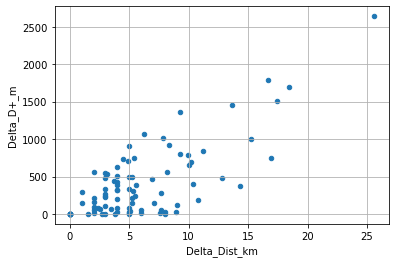

In [146]:
# Affiche tous les segments
print(f"""Nombre de segments: {len(All_trails.df_ppassage)}
      pour une distance totale de: {All_trails.df_ppassage['Delta_Dist_km'].sum()} km
      pour un dénivelé total   de: {All_trails.df_ppassage['Delta_D+_m'].sum()} m  """)
All_trails.df_ppassage.plot.scatter('Delta_Dist_km','Delta_D+_m')
plt.grid()

In [147]:
All_trails.df_ppassage[['Trail','Point_passage','Heure_Passage','Temps_course','H_reel_h_init','H_reel_h','Delta_reel_h_init','Delta_reel_h']]

,Trail,Point_passage,Heure_Passage,Temps_course,H_reel_h_init,H_reel_h,Delta_reel_h_init,Delta_reel_h
0,20195REFUGES,Plaine Joux,Di. 07:28,00:00:00,0.000000,0.000000,0.000000,0.000000
1,20195REFUGES,Refuge Alfred Wills,Di. 10:39,03:11:00,3.183333,3.183333,3.183333,3.183333
2,20195REFUGES,Fontaine Ayere,Di. 12:01,04:32:43,4.545278,4.545278,1.361944,1.361944
3,20195REFUGES,Refuge du Châlet d'Ayères,Di. 12:14,04:46:15,4.770833,4.770833,0.225556,0.225556
4,20195REFUGES,Plaine Joux,Di. 12:30,05:01:51,5.030833,5.030833,0.260000,0.260000
...,...,...,...,...,...,...,...,...
28,2022UTB,Les Jorets,03:53:57,23:53:08,23.885556,22.635556,1.132500,1.132500
29,2022UTB,Les Saisies - Office du Tourisme,04:45:42,24:44:53,24.748056,23.498056,0.862500,0.862500
30,2022UTB,Le Lata du Vaz,06:01:29,26:00:40,26.011111,24.761111,1.263056,1.263056
31,2022UTB,Plan des Maisons,06:54:35,26:53:46,26.896111,25.646111,0.885000,0.885000


### Save Trails in pickle file

In [148]:
PIK = "trails.dat"
with open(PIK, "wb") as f:
    for T in Trails_objects:
        pickle.dump(T, f)
    pickle.dump(All_trails, f)
print('Task completed')

Task completed
